In [80]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install fancyimpute

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
data = pd.read_csv('weatherAUS.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

`RainToday` and `RainTomorrow` are categorical objects with yes/no as categories. I will convert them into 1/0.

In [3]:
print('Shape of the data : {}\n'.format(data.shape))
print('Rows with incomplete data : {}'.format(data[data.isnull().any(axis=1)].shape[0]))

data.head()

Shape of the data : (142193, 24)

Rows with incomplete data : 85773


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [4]:
# Replace Yes/No with 1/0
data.RainToday.replace({'Yes':1,'No':0},inplace=True)
data.RainTomorrow.replace({'Yes':1,'No':0},inplace=True)

## Dealing with class imbalance ##

This data set suffers from class imbalance as shown in the cell below. There are multiple ways to deal with class imbalance, most common of which are :
<ol>
    <li> Random Under sampling </li>
    <li> Random Over sampling </li>
    <li> Cluster based over sampling </li>
    <li> Synthetic Minority Over-sampling Technique </li>
</ol>

I briefly mention details about each of the following techniques below :

### 1. Random Under Sampling ###
This method involves randomly elminating examples from majority class till majority and minority classes balance out.<p>
 >**Advantages**
 <ul> 
    <li> When training set is huge, this method can help save time and costs by reducing number of training samples </li>
 </ul>
 >**Disadvantages**
 <ul>
    <li> We end up discarding potentially useful information</li>
    <li> We might end up choosing outliers/biased samples </li>
 </ul>

### 2. Random Over Sampling ###
This method is same as the one above but here we replicate the minority class samples till the imbalance is eliminated<p>
 >**Advantages**
 <ul> 
    <li> No information loss </li>
 </ul>
 >**Disadvantages**
 <ul>
    <li> Increases chances of overfitting the minority class</li>
 </ul>

### 3. Cluster based over sampling ###
In this case, the K-means clustering algorithm is independently applied to minority and majority class instances. This is to identify clusters in the dataset. Subsequently, each cluster is oversampled such that all clusters of the same class have an equal number of instances and all classes have the same size.  
 >**Advantages**
 <ul> 
    <li> This is good at handling cases where each class is made of different clusters  </li>
 </ul>
 >**Disadvantages**
 <ul>
    <li> This method will not result in equally distributed classes </li>
    <li> Prone to overfitting </li>
 </ul>

### 4. Synthetic Minority Over-sampling Technique ###
Here, we take samples of minority class and generate synthetic samples. These are then added to the original database. The following flow chart shows how this is done.
![](flowchart.png) <br>

Another plot visually showing how the synthetic instances are generated : 
![](syntheticinstances.png)

 >**Advantages**
 <ul> 
    <li> Since minority instances are not replicated, less chances of overfitting  </li>
 </ul>
 >**Disadvantages**
 <ul>
    <li> While generating synthetic samples, all other classes are ignored. This might result in choosing samples which would have otherwise belonged to a different class and thus adding noise to our dataset </li>
    <li> Not very effective in high dimensional data as K-nearest neighbours is used </li>
 </ul>


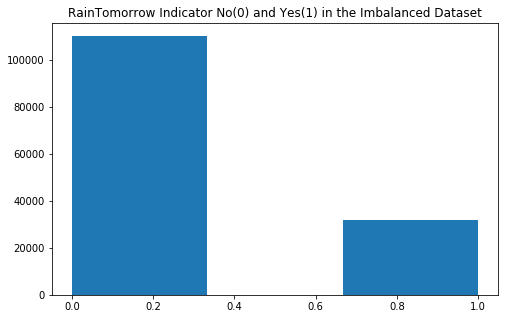

In [5]:
fig = plt.figure(figsize = (8,5))
plt.hist(data.RainTomorrow,bins=3)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

As seen above, the classes are unevenly distributed. I'll upsample the positive classes rather than downsampling the negative class because the imbalance is large and we would end up throwing away important information while downsampling 

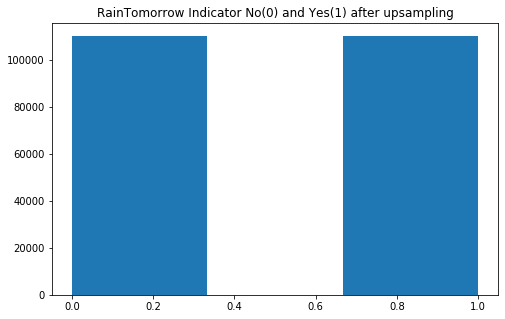

In [6]:
from sklearn.utils import resample
no = data[data.RainTomorrow==0]
yes = data[data.RainTomorrow==1]
yes_oversampled = resample(yes,replace=True, n_samples=len(no), random_state=123)
oversampled_data = pd.concat([no,yes_oversampled],axis=0)

fig = plt.figure(figsize = (8,5))
plt.hist(oversampled_data.RainTomorrow,bins=3)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after upsampling')
plt.show()

Now that we have dealt with class imbalance, I will explore the missing data and impute/drop as required. First, I check the distribution of missing vals (row-wise).

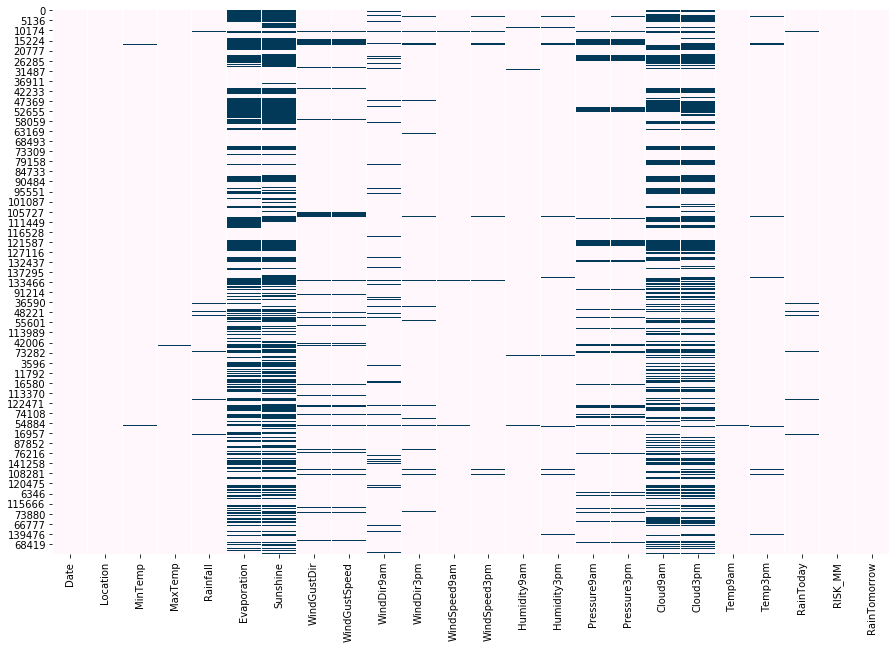

In [7]:
fig = plt.figure(figsize = (15,10))
sns.heatmap(oversampled_data.isnull(),cbar=False,cmap='PuBu')

As observed above, `Evaporation`, `Sunshine`, `Cloud9am` and `Cloud3pm` are features with very high missing values ~40%. But since it's <50%, I will impute the missing values using _Mode_ for categorical features and _Mean_ for continous features.  I'll also do some EDA on the dataset before proceeding to processing the input. First, I'll check the labels to see how the classes are distributed.

In [8]:
missing_val_count = data.isna().sum()
total_rows = data.shape[0]
missing_val_perc = pd.Series([100*count/total_rows for count in missing_val_count])
missing_val_perc.index = missing_val_count.index
print(missing_val_perc)
print('\n\nRows with missing vals = {}'.format(sum(data.isnull().any(axis=1))))

Date              0.000000
Location          0.000000
MinTemp           0.447983
MaxTemp           0.226453
Rainfall          0.988797
Evaporation      42.789026
Sunshine         47.692924
WindGustDir       6.561504
WindGustSpeed     6.519308
WindDir9am        7.041838
WindDir3pm        2.656952
WindSpeed9am      0.948007
WindSpeed3pm      1.849599
Humidity9am       1.247600
Humidity3pm       2.538803
Pressure9am       9.855619
Pressure3pm       9.832411
Cloud9am         37.735332
Cloud3pm         40.152469
Temp9am           0.635756
Temp3pm           1.917113
RainToday         0.988797
RISK_MM           0.000000
RainTomorrow      0.000000
dtype: float64


Rows with missing vals = 85773



There are around 85k rows with atleast one NaN value. Since this is a significant percentage of our data (~60%), it's not advisable to drop the rows. If any column has >50% values missing, it's safe to drop it from the dataset. Note that the task at hand is to predict values for `RainTomorrow` for a given set of data. 

Also, Note that I used the original data set for calculating missing percentage etc. (not oversampled data) as looking at missing value distribution on oversampled data would be misleading due to upsampling.


## Imputation ##

First, I will impute the categorical data by `mode` values and then using label encoder, will convert them into numerical values. For continous variables, I'll impute using MICE package and then calculate IQR to get outliers. Idea is to remove outliers to get to the final dataset

In [9]:
categorical_cols = list(oversampled_data.select_dtypes(include=['object']).columns)
for i in categorical_cols:
    oversampled_data[i] = oversampled_data[i].fillna(oversampled_data[i].mode()[0])

In [10]:
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in categorical_cols:
    lencoders[col] = LabelEncoder()
    oversampled_data[col] = lencoders[col].fit_transform(oversampled_data[col])
    if col =='Date':
        next
    else:
        print('Unique classes for column : {}\n {}'.format(col,list(lencoders[col].classes_)))

Unique classes for column : Location
 ['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek', 'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar', 'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart', 'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport', 'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle', 'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF', 'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale', 'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville', 'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia', 'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera']
Unique classes for column : WindGustDir
 ['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW']
Unique classes for column : WindDir9am
 ['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW']
Unique classes for column : WindDir3pm
 ['E', 'ENE', 'ESE'

## MICE ##

MICE stands for Multiple Imputation via Chained equation. This method assumes that the data is missing at random, thus it is not advised to use this technique if that is not the case. An example of data Missing not at random is when `income` field has missing value and `EmploymentStatus` has Unemployed value in employment database. 

The way MICE works can be divided into the steps below : 
<ol>
<li> A simple imputation, such as imputing the mean, is performed for every missing value in the dataset. These mean imputations can be thought of as “place holders.” </li>
<li> The “place holder” mean imputations for one variable (“var”) are set back to missing. </li>
<li> The observed values from the variable “var” in Step 2 are regressed on the other variables in the imputation model, which may or may not consist of all of the variables in the dataset. In other words, “var” is the dependent variable in a regression model and all the other variables are independent variables in the regression model. These regression models operate under the same assumptions that one would make when performing linear, logistic, or Poison regression models outside of the context of imputing missing data. </li>
<li> The missing values for “var” are then replaced with predictions (imputations) from the regression model. When “var” is subsequently used as an independent variable in the regression models for other variables, both the observed and these imputed values will be used. </li>
<li> Steps 2–4 are then repeated for each variable that has missing data. The cycling through each of the variables constitutes one iteration or “cycle.” At the end of one cycle all of the missing values have been replaced with predictions from regressions that reflect the relationships observed in the data. </li>
<li> Steps 2–4 are repeated for a number of cycles, with the imputations being updated at each cycle. </li>

For more details, visit : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/
    
    

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [12]:
Imputed_data = oversampled_data.copy(deep=True)
imputer = IterativeImputer()
Imputed_data.iloc[:,:] = imputer.fit_transform(oversampled_data)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [13]:
Imputed_data.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RISK_MM          0
RainTomorrow     0
dtype: int64

As observed above, there are no missing values in any of the columns. Note that the Dependent variable `RainTomorrow` had no missing values to begin with. If it had, i'd have dropped the entire row as it would be equivalent to having a test data  but no way to confirm which class it belonged to. Now, I'll IQR and drop outliers.

In [14]:
Q1 = Imputed_data.quantile(0.25)
Q3 = Imputed_data.quantile(0.75)
IQR = Q3-Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.119679
Sunshine            5.947404
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.681346
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RISK_MM             5.200000
RainTomorrow        1.000000
dtype: float64


In [19]:
Imputed_data.shape

(220632, 24)

In [21]:
print('Shape before dropping outliers : {}'.format(Imputed_data.shape))
Imputed_data = Imputed_data[~((Imputed_data < (Q1 - 1.5 * IQR)) |(Imputed_data > (Q3 + 1.5 * IQR))).any(axis=1)]
print('Shape before dropping outliers : {}'.format(Imputed_data.shape))


Shape before dropping outliers : (156852, 24)
Shape before dropping outliers : (156852, 24)


## Dealing with Multicollinearity ##

Next I want to check which features in my dataset are correlated to one another. Highly correlated features are undesirable as they do not add information to the data. A simple way to understand why collinearity is a problem is to look at the below :

Consider we have an equation : Y = $b_{0}$ +$b_{1}$X+$b_{2}$Z+e <p>
Then the coefficient $b_{1}$ is the increase in Y for every unit increase in X while holding Z constant. But in practice, it is often impossible to hold Z constant and the positive correlation between X and Z mean that a unit increase in X is usually accompanied by some increase in Z at the same time.

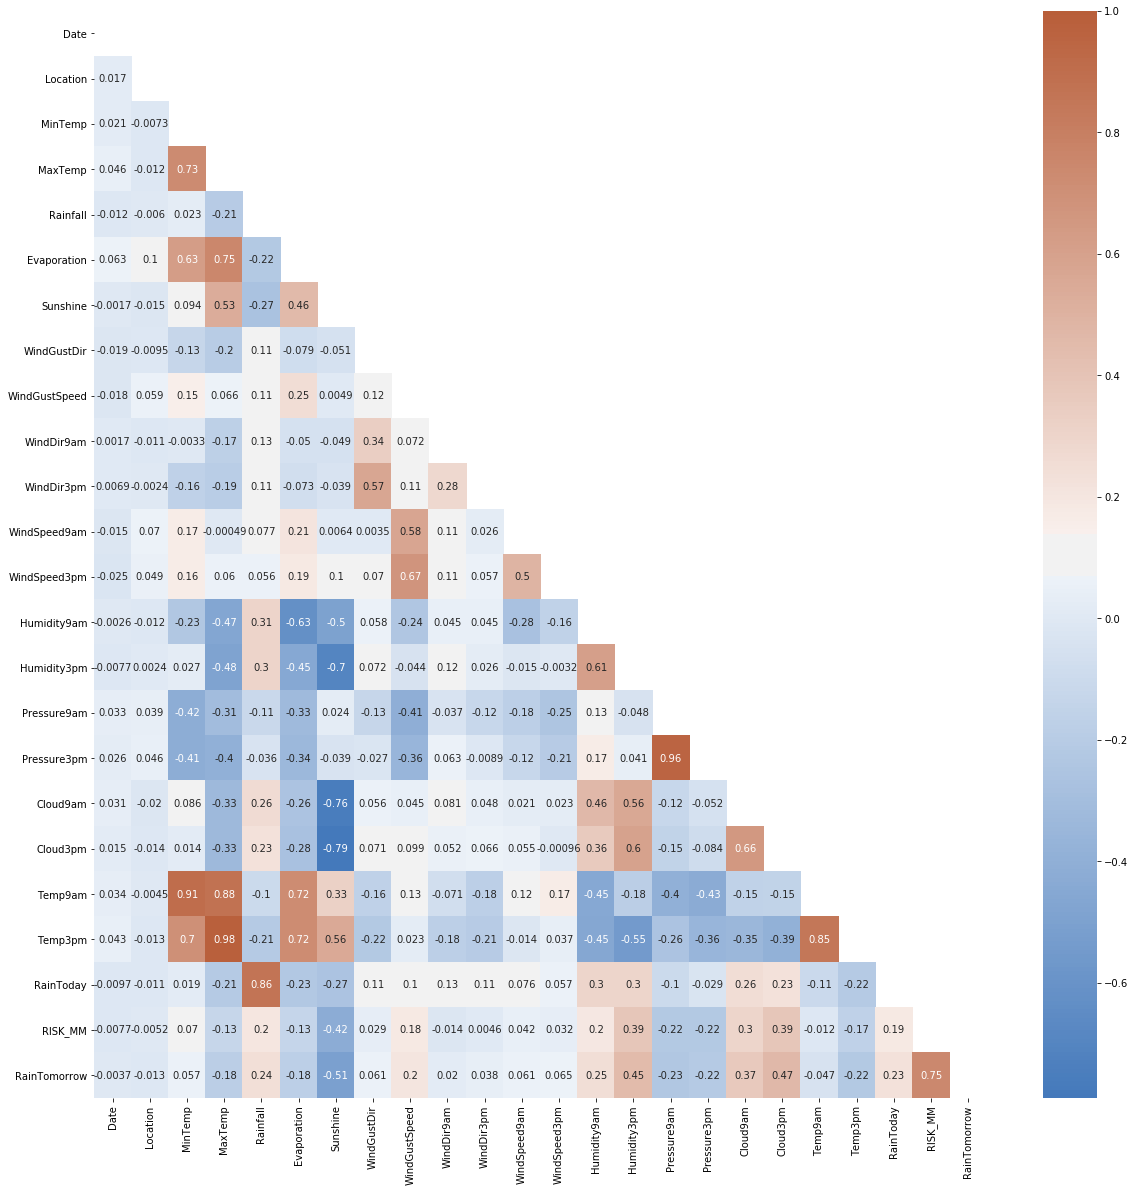

In [22]:
corr_matrix = Imputed_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
fig,ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr_matrix,mask=mask,cmap = cmap,annot=True)

As seen from above heatmap, following quantities are highly correlated :
<ol>
    <li> `MaxTemp` and `MinTemp` </li>
    <li> `Evaporation` and `MaxTemp` </li>
    <li> `Pressure9am` and `Pressure3pm` </li>
    <li> `Cloud9am` and `Sunshine` </li>
    <li> `Cloud3pm` and `Sunshine` </li>
    <li> `Temp9am` and `MinTemp` </li>
    <li> `Temp3pm` and `MaxTemp` </li>
    <li> `Temp3pm` and `Temp9am </li>
 </ol>
 These are highly correlated but since it's not a perfect 1, I want to dive deeper into this. I will draw pairplots and see how the decision boundary looks for each of these pairs
    
  


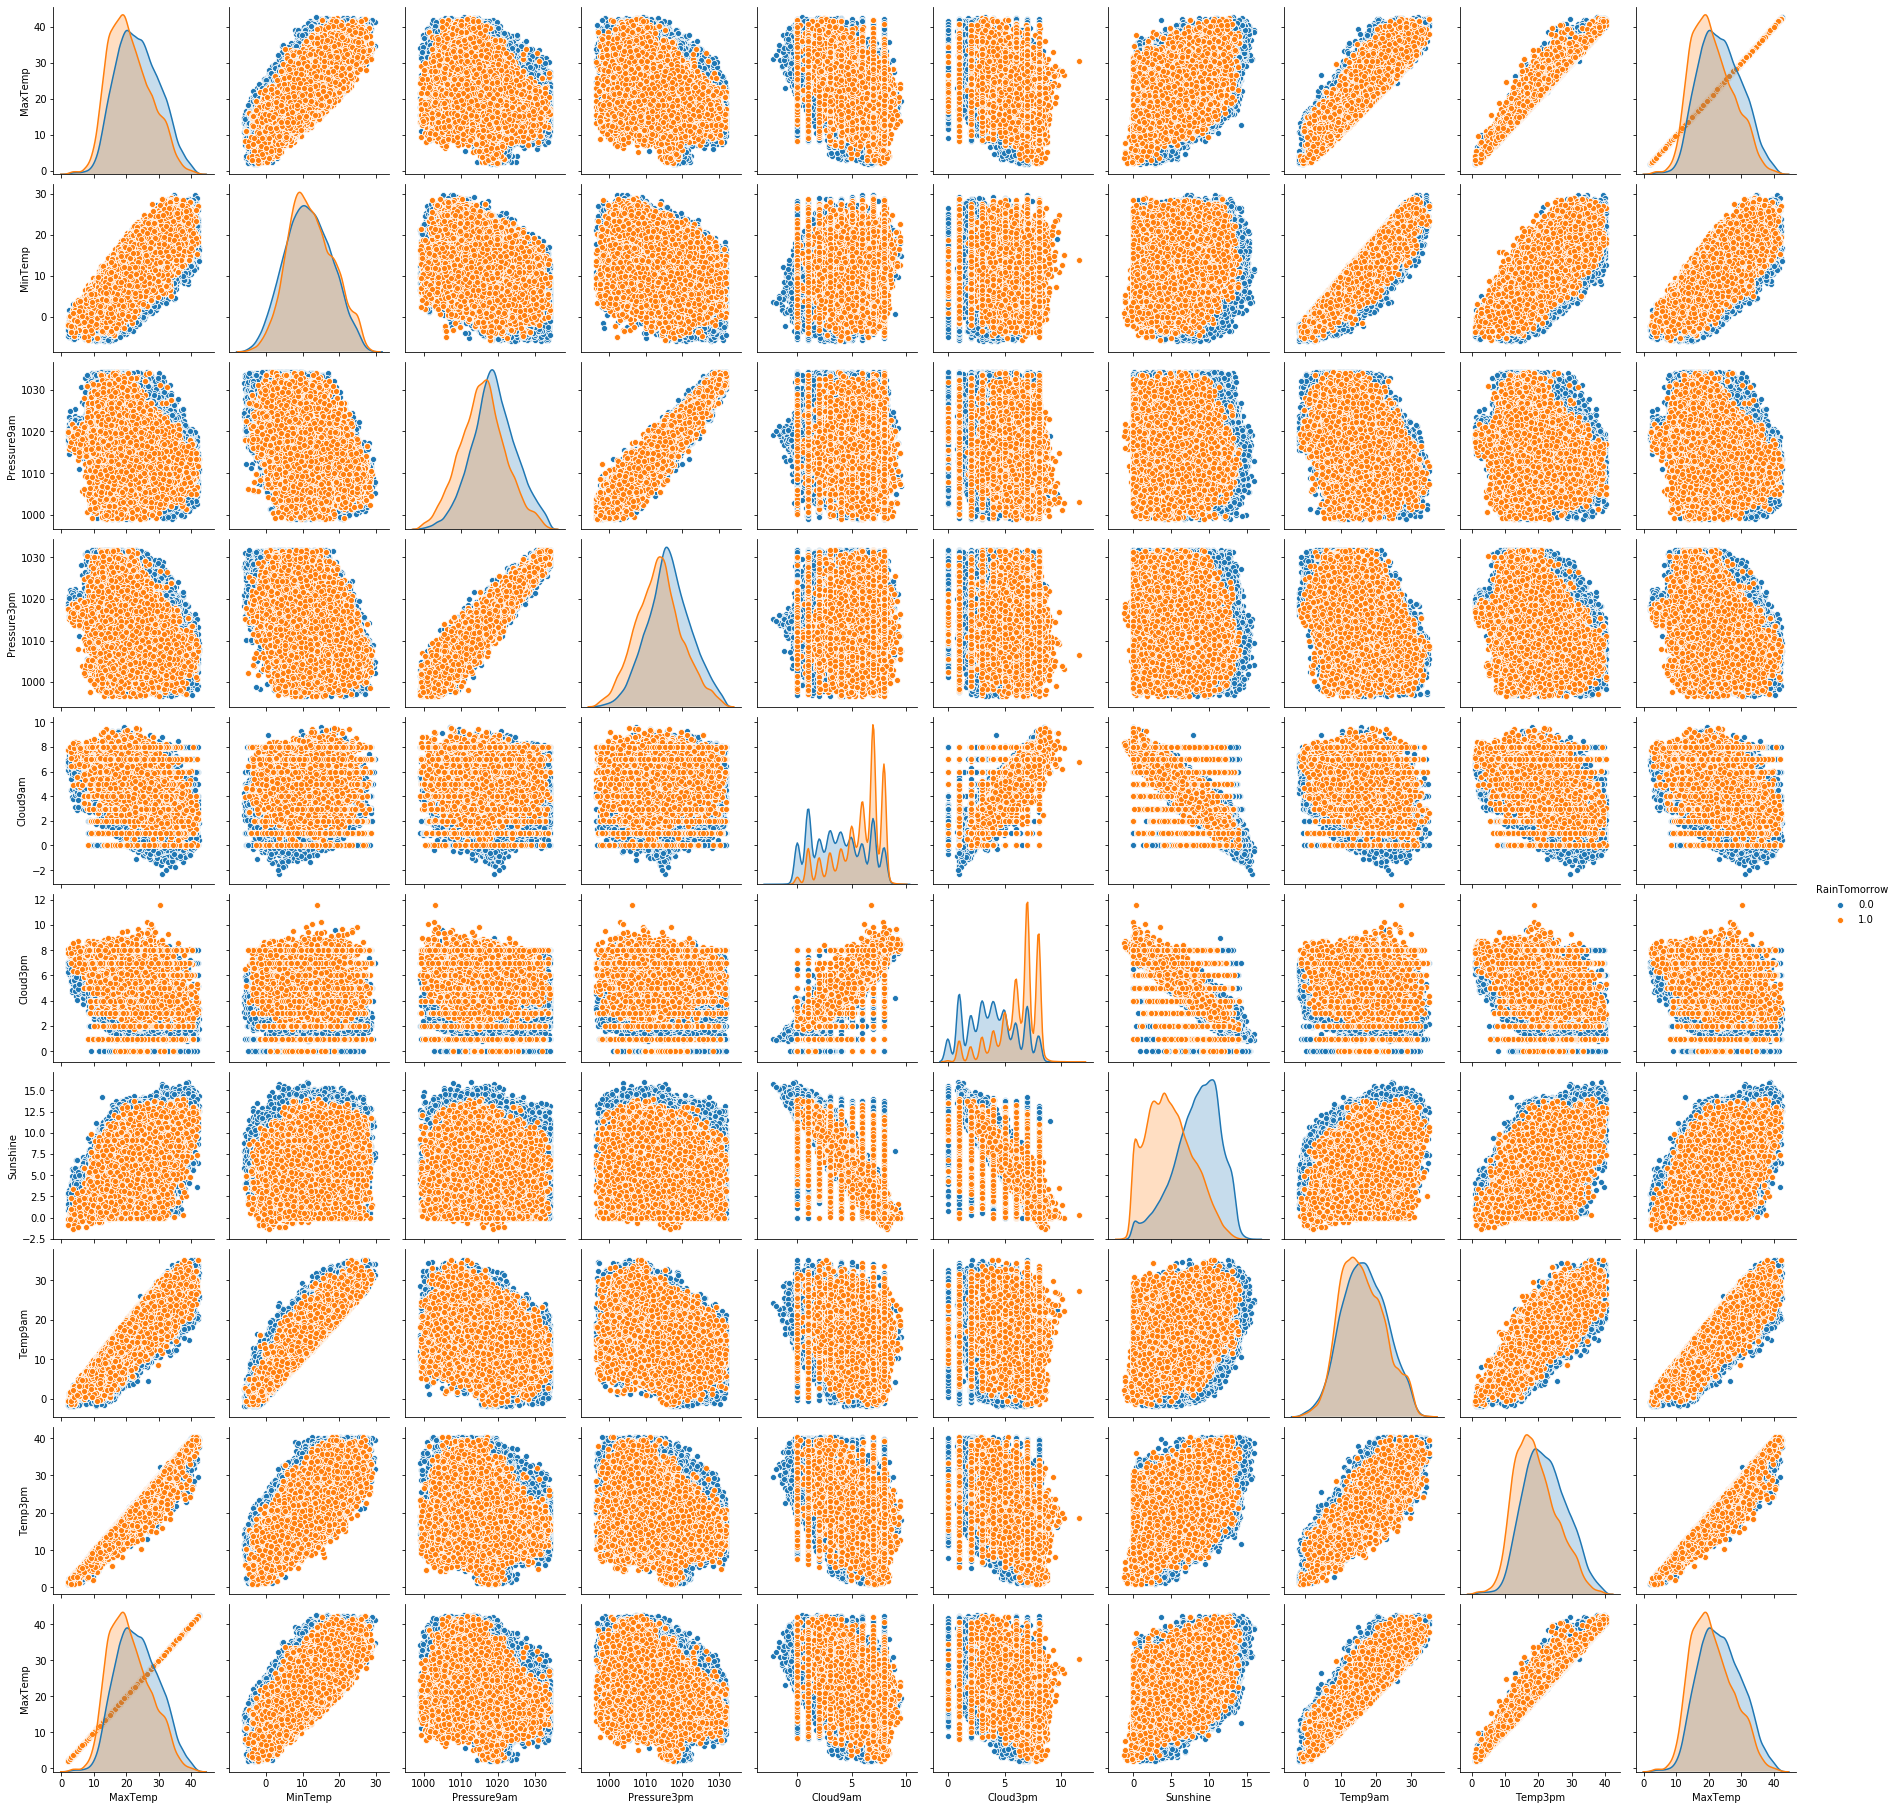

In [42]:
sns.pairplot(Imputed_data,vars=['MaxTemp','MinTemp','Pressure9am','Pressure3pm','Cloud9am','Cloud3pm','Sunshine','Temp9am','Temp3pm','MaxTemp'], hue='RainTomorrow')

As seen above, Each of the paired plots shows very clearly distinct clusters of RainTomorrow’s “yes” and “no” clusters. There is very minimal overlap between them. Thus, I am not dropping any one of them

## Feature Selection ##
There are multiple methods to select features depending on the task at hand. Following flow chart summarizes the options available.<p>
<img src="Overview-of-Feature-Selection-Techniques3.png" width="800" height="800" align="center"/><p>

As seen above, I can either use wrapper method or a filter method to select feature. Wrapper method involves creating a model and seeing which features contribute most to prediction of target variable while filter method involve using statistical analyses to select features. In this case, I'm going with wrapper method. I'll use ExtraTreesClassifier() from sklearn library to do feature selection    

In [24]:
Imputed_data.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

In [34]:
from sklearn.ensemble import ExtraTreesClassifier
X = Imputed_data.iloc[:,:-1]
y = Imputed_data.iloc[:,-1]
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)

clf.fit(X, y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

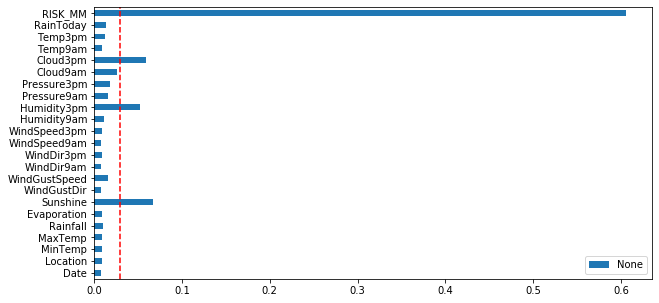

In [41]:
feature_importance_list = pd.Series(clf.feature_importances_,index = X.columns)
fig, ax = plt.subplots(figsize = (10,5))
feature_importance_list.plot(kind='barh')
plt.axvline(x=0.03,color='red',ls='--')
plt.legend()

`RISK_MM` is the most important feature for classification as seen above. So much so that it overshadows other features by a huge margin (even `RainToday`, as Senator Palpatine once said : A surprise to be sure, but a welcome one). In this case, I choose to keep `RISK_MM`,`Cloud3pm`,`Humidity3pm`,`Sunshine` and drop others. Before I proceed to modelling, I'll normalize numerical features using MinMaxScaler (would result in non negative values) 

In [47]:
from sklearn.model_selection import train_test_split
features = ['RISK_MM','Cloud3pm','Humidity3pm','Sunshine']
X = Imputed_data.loc[:,features]
y = Imputed_data.loc[:,'RainTomorrow']

splitfrac = 0.25

train_X,val_X,train_y,val_y = train_test_split(X,y,test_size=splitfrac, random_state=42)


In [50]:
# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
val_X = scaler.fit_transform(val_X)

In [59]:
#Check df sizes
print('Training Data set size : {}'.format(train_X.shape))
print('Training Labels size : {}'.format(train_y.shape))
print('Test Data set size : {}'.format(val_X.shape))
print('Test Label size : {}'.format(val_y.shape))
train_X = pd.DataFrame(train_X)
val_X = pd.DataFrame(val_X)


Training Data set size : (117639, 4)
Training Labels size : (117639,)
Test Data set size : (39213, 4)
Test Label size : (39213,)


Now I'll move on to modelling. First, I'll create and sve csv files for training and validation. Then upload them to s3 so our model can access them

In [93]:
import os
data_dir = '../data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [94]:
#Create new training and validation datasets

prefix='rainfall-'
pd.concat([pd.DataFrame(train_y[:,np.newaxis]),train_X], axis=1).to_csv(os.path.join(data_dir,'train.csv'),header=False,index=False)
pd.concat([pd.DataFrame(val_y[:,np.newaxis]),val_X], axis=1).to_csv(os.path.join(data_dir,'validation.csv'),header=False,index=False)


In [82]:
session = sagemaker.Session()
role = get_execution_role()

val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix,content_type='Line/')
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## Modelling in SageMaker ##
I'll use XGBoost to model the data in sagemaker, then use hyperparameter tuning to set optimal parameters

In [88]:
container = sagemaker.image_uris.retrieve('xgboost',session.boto_region_name,'latest')

xgb = sagemaker.estimator.Estimator(container, 
                                    role,      
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session) 

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [97]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:logistic',
                        eval_metric = 'auc',
                        early_stopping_rounds=10,
                        num_round=200)

In [98]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data=val_location, content_type='csv')
xgb.fit({'train':s3_input_train,'validation':s3_input_validation})

2021-01-08 07:19:20 Starting - Starting the training job...
2021-01-08 07:19:45 Starting - Launching requested ML instancesProfilerReport-1610090360: InProgress
......
2021-01-08 07:20:46 Starting - Preparing the instances for training......
2021-01-08 07:21:46 Downloading - Downloading input data
2021-01-08 07:21:46 Training - Downloading the training image..Arguments: train
[2021-01-08:07:22:03:INFO] Running standalone xgboost training.
[2021-01-08:07:22:03:INFO] File size need to be processed in the node: 12.35mb. Available memory size in the node: 8432.8mb
[2021-01-08:07:22:03:INFO] Determined delimiter of CSV input is ','
[07:22:03] S3DistributionType set as FullyReplicated
[07:22:03] 117639x4 matrix with 470556 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-01-08:07:22:03:INFO] Determined delimiter of CSV input is ','
[07:22:03] S3DistributionType set as FullyReplicated
[07:22:03] 39213x4 matrix with 156852 entries loaded from /opt/ml/inp